In [0]:
import numpy as np
import cv2
from math import sqrt
import matplotlib.pyplot as plt

### 1. Capturamos el primer frame para obtener la matríz de homografía



In [0]:
capture = cv2.VideoCapture('TownCentreXVID.avi')
ret, frame = capture.read()
print(ret)
cv2.imwrite('calibration_frame.jpg', frame)
capture.release()

True


Image size:  (1080, 1920, 3)


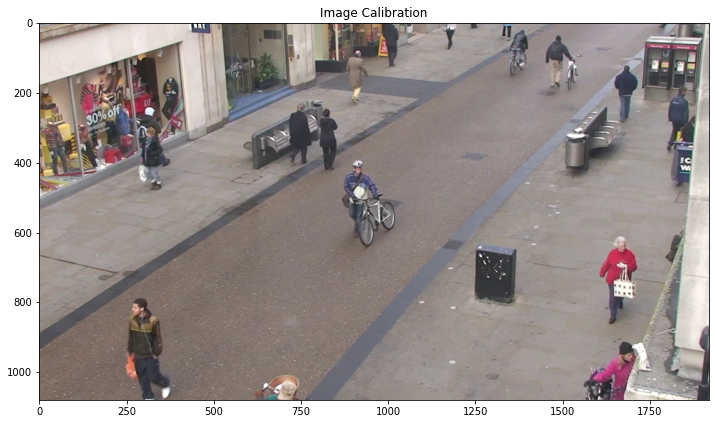

In [0]:
image_original = cv2.cvtColor(cv2.imread('calibration_frame.jpg'), cv2.COLOR_BGR2RGB) 
image_calibration = image_original.copy()
print("Image size: ", image_calibration.shape)
plt.figure(figsize=(12, 12))
plt.title("Image Calibration")
plt.imshow(image_calibration)
plt.show()

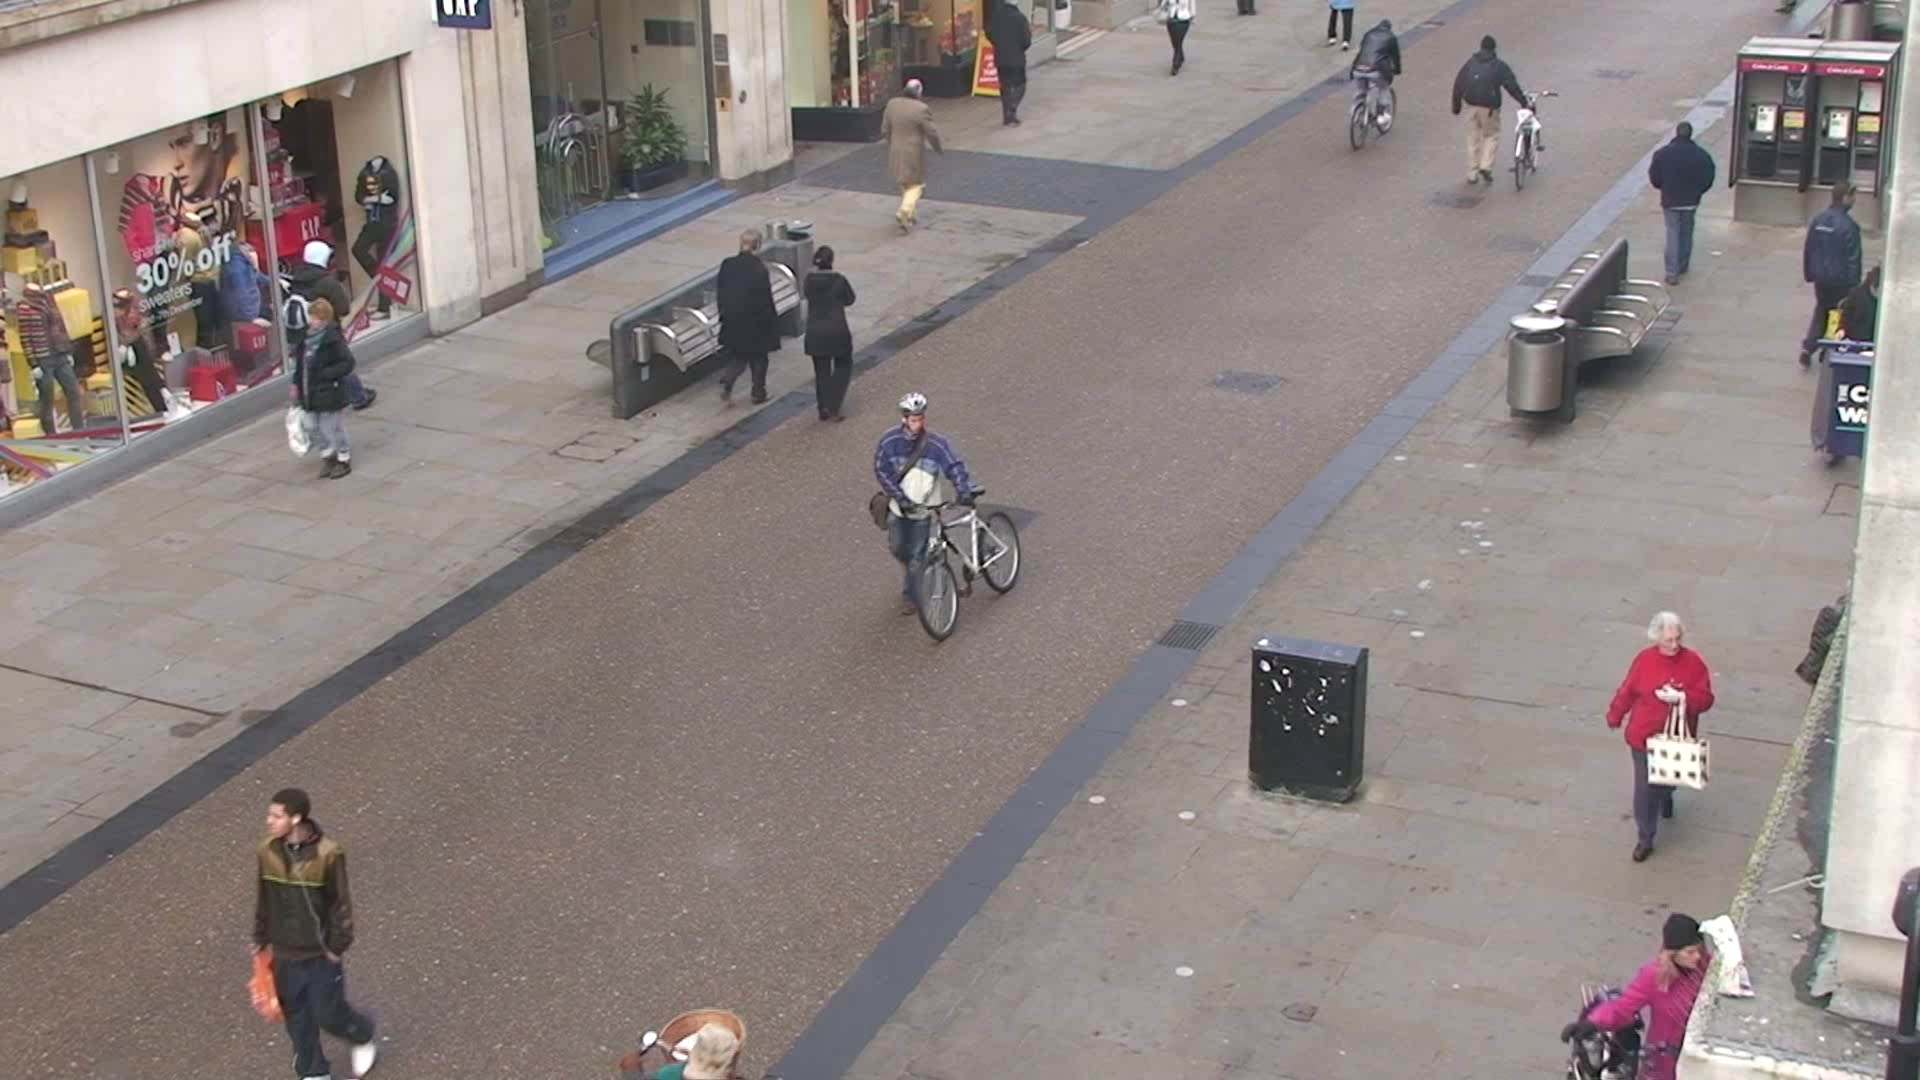

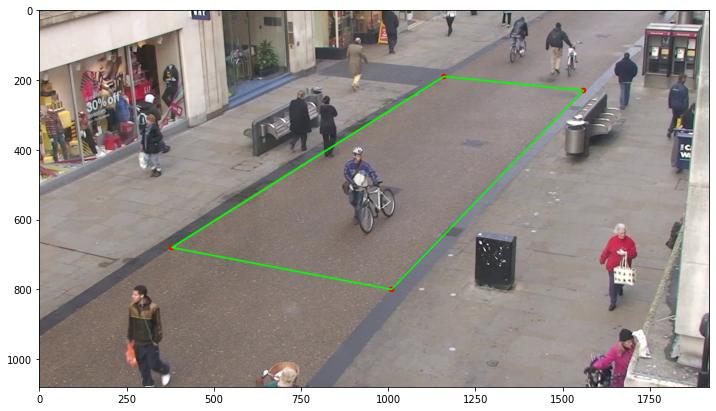

In [0]:
# Finding points on the calibration image
source_points = np.float32([[1160, 190], [1560, 230], [1010, 800], [380, 680]])
image_calibration_points = image_calibration.copy()

# Drawing points from calibration image
for point in source_points:
  cv2.circle(image_calibration_points, tuple(point), 8, (255, 0, 0), -1)

# Drawing lines to join the points
points = source_points.reshape((-1,1,2)).astype(np.int32)
cv2.polylines(image_calibration_points, [points], True, (0,255,0), thickness=4)

plt.figure(figsize=(12, 12))
plt.imshow(image_calibration_points)
plt.show()

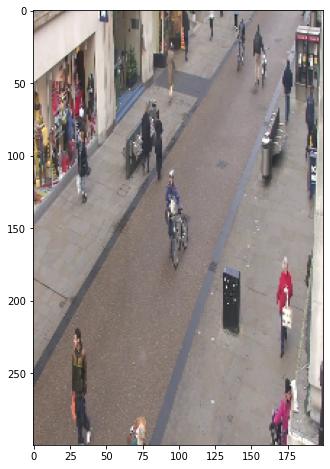

In [0]:
# Mapping to other perspective
width = 200
height = 300

# Finding points to destination perspective
(img_height, img_width) = image_calibration.shape[:2]
src_points = np.float32([[0, 0], [img_width, 0], [img_width, img_height], [0, img_height]])
dest_points = np.float32([[0,0], [width, 0], [width, height], [0, height]])

# Perspective transformation
matrix = cv2.getPerspectiveTransform(src_points, dest_points)
result = cv2.warpPerspective(image_calibration, matrix, (width, height))

#plt.rc('grid', linestyle='-', color='blue')
plt.figure(figsize=(8, 8))
plt.imshow(result)
#plt.yticks(np.arange(0, 300, step=10))
#plt.xticks(np.arange(0, 200, step=10))
#plt.grid(True)
plt.show()

In [0]:
print(source_points)

[[1160.  190.]
 [1560.  230.]
 [1010.  800.]
 [ 380.  680.]]


In [0]:
roi_corners=[[0.38*image_calibration.shape[1] ,   0                           ],
             [0.62*image_calibration.shape[1] ,   0                           ],
             [image_calibration.shape[1]      ,   image_calibration.shape[0]  ],
             [0                               ,   image_calibration.shape[0]  ]]
roi_corners  = source_points
show_roi=True
if show_roi:
    src = np.float32(roi_corners)
    pts = np.array(src, np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(image_calibration,[pts],True,(255,0,0),10)

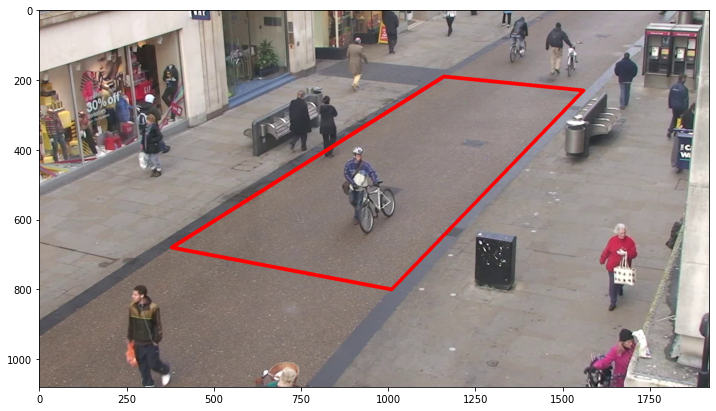

In [0]:
plt.figure(figsize=(12,12))
plt.imshow(image_calibration)
plt.show()

In [0]:
def unwarp(img, roi_corners):
    src = np.float32(roi_corners)
    warped_size=(img.shape[1], img.shape[0])
    #print("Original:", warped_size)
    #offset=int(warped_size[0]/2.4)
    #dst = np.float32([[offset               , 0               ], 
    #                  [warped_size[0]-offset, 0               ],  
    #                  [warped_size[0]-offset, warped_size[1]  ], 
    #                  [offset               , warped_size[1]  ]])
    dest = np.float32([
                       [],
                       [],
                       [],
                       []
                       ])
    print(dst)
    tansform = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, tansform, warped_size)
    return warped

Original: (1920, 1080)
[[ 800.    0.]
 [1120.    0.]
 [1120. 1080.]
 [ 800. 1080.]]


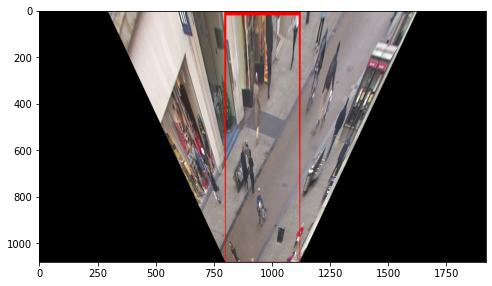

In [0]:
image = unwarp(image_calibration, roi_corners)
plt.figure(figsize=(8,8))
plt.imshow(image)
plt.show()

###2. Detector de personas con YOLOv3


[[312, 932], [910, 154], [1683, 195], [1500, 110], [1664, 733], [1376, 71], [1006, 57], [827, 338], [1175, 35], [757, 320], [325, 387], [1829, 271], [1650, 988], [1341, 18]]


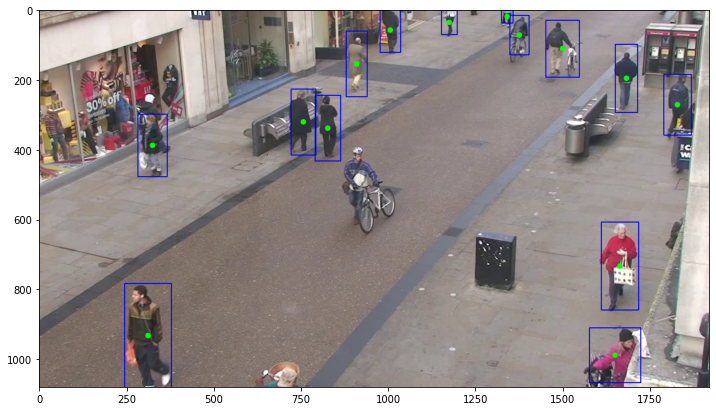

In [0]:
#Referencia: https://www.learnopencv.com/deep-learning-based-object-detection-using-yolov3-with-opencv-python-c/
confidence_threshold = 0.5
nms_threshold = 0.5
input_width = 416
input_height = 416
model_config_name = 'yolov3.cfg'
model_weights_name = 'yolov3.weights'
model_classes_name = 'coco.names'
classes = None
with open(model_classes_name, 'rt') as f:
  classes = f.read().strip('\n').split('\n')


#W = None
#H = None
#writer = None

"""
video = cv2.VideoCapture('TownCentreXVID.avi')

while True:
  _, frame = video.read()

  if frame is None:
    break

  if W is None or H is None:
    (H, W) = frame.shape[:2]
  
  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    writer = cv2.VideoWriter('output_video.avi', fourcc, 30, (W, H), True)
  
  img_color = cv2.cvtColor(frame, cv2.COLOR_GBR2RGB)
"""

# Step 1: Create the model
model = cv2.dnn.readNetFromDarknet(model_config_name, model_weights_name)
model.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
model.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Step 2: Get the Output Layers
layer_names = model.getLayerNames()
output_names = [layer_names[i[0]-1] for i in model.getUnconnectedOutLayers()]

# Step 3: Read the image or frame (video)
image = cv2.cvtColor(cv2.imread('calibration_frame.jpg'), cv2.COLOR_BGR2RGB)

# Step 4: Create blob from image or frame
blob = cv2.dnn.blobFromImage(image, 
                             1/255., 
                             (input_width, input_height), 
                             [0,0,0],
                             1,
                             crop=False)

# Step 5: Set input to model and do forward pass
model.setInput(blob)
outputs = model.forward(output_names)

# Step 6: Apply non maximum supression
#frame = image, outs = outputs
img_height = image.shape[0]
img_width = image.shape[1]
classIds = []
confidences = []
boxes = []
for output in outputs:
  for detection in output:
    scores = detection[5:]
    classId = np.argmax(scores)
    confidence = scores[classId]
    if confidence > confidence_threshold:
      center_x = int(detection[0] * img_width)
      center_y = int(detection[1] * img_height)
      width = int(detection[2] * img_width)
      height = int(detection[3] * img_height)
      left = int(center_x - width / 2)
      top = int(center_y - height / 2)
      classIds.append(classId)
      confidences.append(float(confidence))
      boxes.append([left, top, width, height])
 

indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)
centers = []
# Step 7: Draw Bounding boxes
for index in indices:
  index = index[0]
  i_class = classes[classIds[index]]
  if i_class == 'person':  
    box = boxes[index]
    left = box[0]
    top = box[1]
    width = box[2]
    height = box[3]
    center_x = left + int(width / 2)
    center_y = top + int(height / 2)
    centers.append([center_x, center_y])
    cv2.circle(image, (center_x, center_y), 8, (0, 255, 0), -1)
    cv2.rectangle(image, (left, top), (left + width, top + height), (0,0,255), 2)
    #i_label = f'{confidences[index]:.2f}'
    #label = f'{str(i_class)}:{str(i_label)}'
    #label_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.)
    #top = max(top, label_size[1])
    #cv2.putText(image, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 1., (0,0,255))
print(centers)    

plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.show()

###3. Detector de personas con YOLOv3 (video)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.77 µs
[(791, 244, 74, 188, 828, 338), (721, 227, 72, 188, 757, 321)]
71.26794250507201


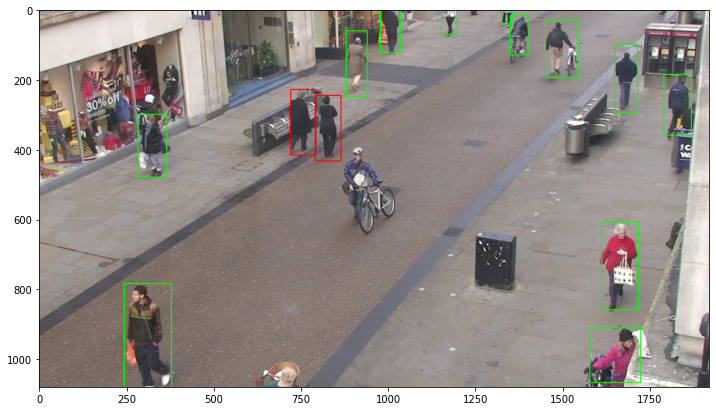

[(722, 225, 70, 188, 757, 319), (794, 233, 68, 188, 828, 327)]
59.28624945971873


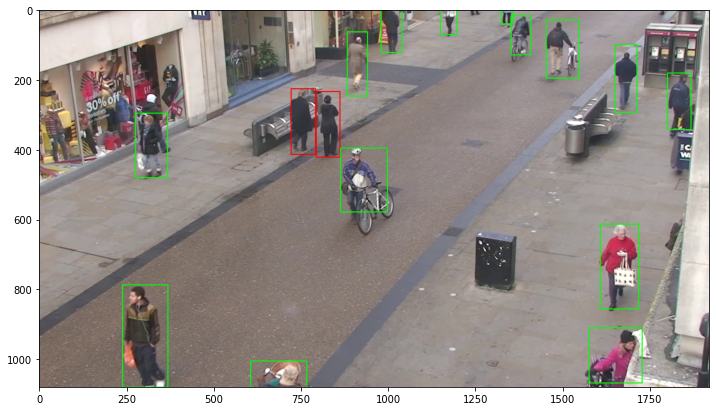

[(724, 225, 72, 181, 760, 315), (796, 236, 70, 181, 831, 326)]
63.10787399180569


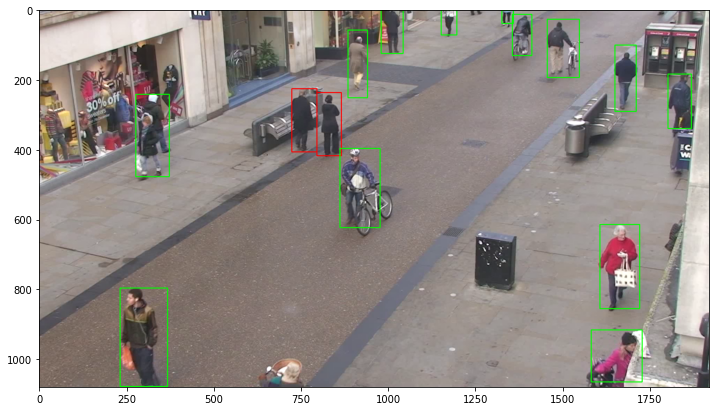

[(731, 223, 72, 190, 767, 318), (800, 234, 69, 184, 834, 326)]
56.46452149358923


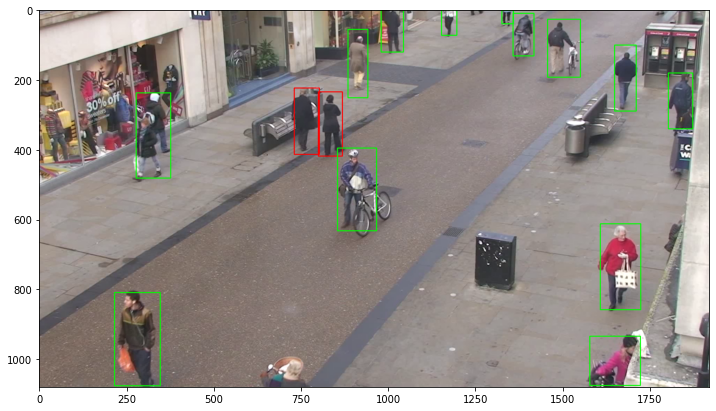

[(806, 233, 73, 185, 842, 325), (733, 219, 75, 195, 770, 316)]
61.22314262890607


In [0]:
#Referencia: https://www.learnopencv.com/deep-learning-based-object-detection-using-yolov3-with-opencv-python-c/
%time
confidence_threshold = 0.5
nms_threshold = 0.5
input_width = 416
input_height = 416
MINIMAL_DISTANCE = 100
color_green = (0, 255, 0)
color_red = (255, 0, 0)
model_config_name = 'yolov3.cfg'
model_weights_name = 'yolov3.weights'
model_classes_name = 'coco.names'
classes = None
with open(model_classes_name, 'rt') as f:
  classes = f.read().strip('\n').split('\n')


W = None
H = None
writer = None
count = 0
# Step 1: Create the model
model = cv2.dnn.readNetFromDarknet(model_config_name, model_weights_name)
model.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
model.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Step 2: Get the Output Layers
layer_names = model.getLayerNames()
output_names = [layer_names[i[0]-1] for i in model.getUnconnectedOutLayers()]

video = cv2.VideoCapture('TownCentreXVID.avi')

while True:
  _, frame = video.read()

  if frame is None:
    break

  if count >= 300:
    break
  count = count + 1
  if W is None or H is None:
    (H, W) = frame.shape[:2]

  if writer is None:
    fourcc = cv2.VideoWriter_fourcc(*"MJPG") #MP4V
    writer = cv2.VideoWriter('output_video.avi', fourcc, 30, (W, H), True)

  # Step 3: Read the image or frame (video)
  image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

  # Step 4: Create blob from image or frame
  blob = cv2.dnn.blobFromImage(image, 
                              1/255., 
                              (input_width, input_height), 
                              [0,0,0],
                              1,
                              crop=False)

  # Step 5: Set input to model and do forward pass
  model.setInput(blob)
  outputs = model.forward(output_names)

  # Step 6: Apply non maximum supression
  #frame = image, outs = outputs
  img_height = image.shape[0]
  img_width = image.shape[1]
  classIds = []
  confidences = []
  boxes = []
  for output in outputs:
    for detection in output:
      scores = detection[5:]
      classId = np.argmax(scores)
      confidence = scores[classId]
      if confidence > confidence_threshold:
        center_x = int(detection[0] * img_width)
        center_y = int(detection[1] * img_height)
        width = int(detection[2] * img_width)
        height = int(detection[3] * img_height)
        left = int(center_x - width / 2)
        top = int(center_y - height / 2)
        classIds.append(classId)
        confidences.append(float(confidence))
        boxes.append([left, top, width, height])

  indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)

  # Step 7: Draw Bounding boxes
  people_boxes = []

  for index in indices:
    index = index[0]
    i_class = classes[classIds[index]]
    if i_class == 'person':  
      box = boxes[index]
      left = box[0]
      top = box[1]
      width = box[2]
      height = box[3]
      center_x = left + int(width / 2)
      center_y = top + int(height / 2)
      people_boxes.append((left, top, width, height, center_x, center_y))

  people_bad_distances = []
  people_good_distances = []

  for i in range(0, len(people_boxes)-1):
    for j in range(i+1, len(people_boxes)):
      _,_,_,_,cxi,cyi = people_boxes[i]
      _,_,_,_,cxj,cyj = people_boxes[j]

      #mapear distancias other perspective
      matrix_transf = np.array([[ 1.14199333e+00,  6.94076400e+00,  8.88203441e+02],
       [-5.13279159e-01,  7.26783411e+00,  1.02467130e+03],
       [ 9.79674124e-07,  1.99580075e-03,  1.00000000e+00]])
      result = cv2.perspectiveTransform(np.array([[[cxi, cyi], [cxj, cyj]]], dtype='float32'), matrix_transf)
      cxi, cyi = result[0][0]
      cxj, cyj = result[0][1]
      ##

      x = cxi - cxj
      y = cyi - cyj
      distance = sqrt(x*x + y*y)
      if(distance < MINIMAL_DISTANCE):
        people_bad_distances.append(people_boxes[i])
        people_bad_distances.append(people_boxes[j])
  print(people_bad_distances)
  people_good_distances = list(set(people_boxes) - set(people_bad_distances))
  people_bad_distances = list(set(people_bad_distances))

  for person in people_bad_distances:
    left, top, width, height, cx, cy = person
    cv2.rectangle(image, (left, top), (left + width, top + height), color_red, 2)

  for i in range(0, len(people_bad_distances)-1):
    for j in range(i+1, len(people_bad_distances)):
      _,_,_,_,cxi,cyi = people_bad_distances[i]
      _,_,_,_,cxj,cyj = people_bad_distances[j]

      #mapear distancias other perspective
      matrix_transf = np.array([[ 1.14199333e+00,  6.94076400e+00,  8.88203441e+02],
       [-5.13279159e-01,  7.26783411e+00,  1.02467130e+03],
       [ 9.79674124e-07,  1.99580075e-03,  1.00000000e+00]])
      result = cv2.perspectiveTransform(np.array([[[cxi, cyi], [cxj, cyj]]], dtype='float32'), matrix_transf)
      cxi, cyi = result[0][0]
      cxj, cyj = result[0][1]
      ##

      x = cxi - cxj
      y = cyi - cyj
      distance = sqrt(x*x + y*y)
      print(distance)
      if(distance < MINIMAL_DISTANCE): 
        cv2.line(image, (cxi, cyi), (cxj, cyj), color_red, 2)

  for person in people_good_distances:
    left, top, width, height, cx, cy = person
    cv2.rectangle(image, (left, top), (left + width, top + height), color_green, 2)

  plt.figure(figsize=(12, 12))
  plt.imshow(image)
  plt.show()

  if writer is not None:
    writer.write(image[:,:,::-1])

if writer is not None:
  writer.release()

video.release()

#plt.figure(figsize=(12, 12))
#plt.imshow(image)
#plt.show()

In [0]:
#points = [[312, 932], [910, 154], [1683, 195], [1500, 110], [1664, 733], [1376, 71], [1006, 57], [827, 338], [1175, 35], [757, 320], [325, 387], [1829, 271], [1650, 988], [1341, 18]]

matrix_transf = np.array([[ 1.14199333e+00,  6.94076400e+00,  8.88203441e+02],
       [-5.13279159e-01,  7.26783411e+00,  1.02467130e+03],
       [ 9.79674124e-07,  1.99580075e-03,  1.00000000e+00]])

points = np.array([[[312, 932],[910, 154]]], dtype='float32')
result = cv2.perspectiveTransform(points, matrix_transf)
print(result[0][1])

[2290.3167 1281.743 ]
